# Our First Reinforcement Learning from Feedback Loop*

\* it is not human preferencies as we are using two models to provide feedback

### Import dependencies

In [ ]:
import random
import wandb
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt

tqdm.pandas()

from datasets import load_dataset

from transformers import AutoTokenizer, pipeline

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, \
                create_reference_model, AutoModelForSeq2SeqLMWithValueHead
import os
import torch


# from accelerate import Accelerator
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda")

device


# The Reward Pipeline

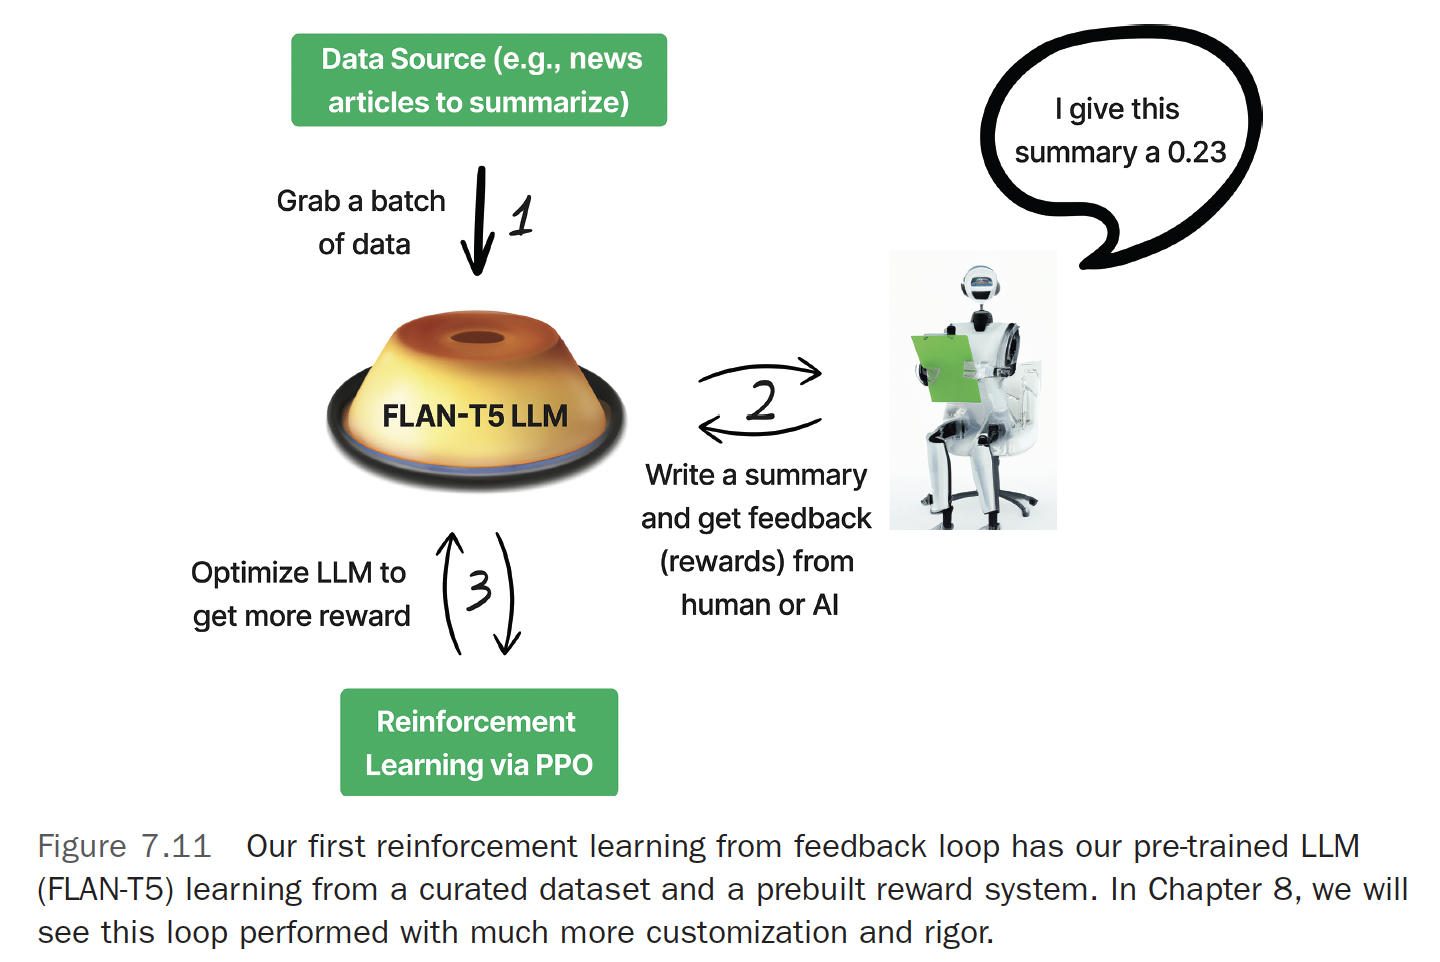

In [24]:
sentiment_pipeline = pipeline('text-classification', 'cardiffnlp/twitter-roberta-base-sentiment')

def get_neutral_scores(texts):
    scores = []
    # note function_to_apply='none' gives me logits which can be negative, 
    # instead of softmaxed probabilities
    results = sentiment_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  #  neutral
                scores.append(label['score'])
    return scores
      
get_neutral_scores(['hello', 'I love you!', 'I hate you'])

[0.8519178032875061, -0.7468030452728271, -0.5696870684623718]

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("textattack/roberta-base-CoLA")
model = AutoModelForSequenceClassification.from_pretrained("textattack/roberta-base-CoLA")

cola_pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer)

def get_cola_scores(texts):
    scores = []
    # note function_to_apply='none' gives me logits which can be negative (what we want), 
    # instead of softmaxed probabilities
    results = cola_pipeline(texts, function_to_apply='none', top_k=None)
    for result in results:
        for label in result:
            if label['label'] == 'LABEL_1':  # good grammar:
                scores.append(label['score'])
    return scores
      

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
test = """German police arrest 29-year-old man suspected of plotting truck attack on ice rink in Berlin, 
killing 12 people, Reuters-German police say: 'It's a shame to have been arrested,' 
a German police spokesman said in a statement."""

print(get_cola_scores([test]))
print(get_neutral_scores([test]))

[-0.03150774538516998]
[0.30984681844711304]


# RL Configuration

In [ ]:
config = PPOConfig(
    model_name="google/flan-t5-small",
    # this is a memory intensive process as we are to use two flan-t5 models,
    # so we use a small batch size. Also, notice that we are not passing ground truth data, which
    # means this will be a slow process
    batch_size=4,
    learning_rate=2e-5,
    remove_unused_columns=False,
    log_with="wandb",  # weights and biases logging
    # reduces memory overhead by not updating gradients for every batch, but every 8 batches
    # it increases the data seen by the model before updating the weights
    gradient_accumulation_steps=8,  
)

np.random.seed(42)

In [18]:
flan_t5_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
    config.model_name  # we are using flan_t5 seq2seq model (it is not auto-regressive as GPT-2)
)  # this model going to be updated

flan_t5_model_ref = create_reference_model(flan_t5_model)  # this model is never updated
flan_t5_tokenizer = AutoTokenizer.from_pretrained(config.model_name)  # tokenizer for the model. It is static, never updated


In [19]:
from datasets import load_dataset


# this is a cool dataset of news articles, and their respective summaries,
# that can be used for fine-tuning. We are not using the summaries for our task
dataset = load_dataset("argilla/news-summary")

Using custom data configuration argilla--news-summary-46ccad7a40bceec1
Found cached dataset parquet (C:/Users/sinan/.cache/huggingface/datasets/argilla___parquet/argilla--news-summary-46ccad7a40bceec1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'prediction', 'prediction_agent', 'annotation', 'annotation_agent', 'id', 'metadata', 'status', 'event_timestamp', 'metrics'],
        num_rows: 20417
    })
})

In [21]:
dataset['train'][0]

{'text': 'PHNOM PENH (Reuters) - Sweden said on Tuesday it was stopping new aid for Cambodia, except in education and research, and would no longer support a reform programme after the main opposition party was outlawed by the Supreme Court at the government s request. The announcement marked the first concrete action by a European Union country in protest at a political crackdown in which veteran Prime Minister Hun Sen s main rival has also been arrested and civil rights groups and independent media attacked. The United States cut election funding and said it would take more punitive steps after last week s ban on the Cambodia National Rescue Party (CNRP). The European Union has also threatened action. Sweden s embassy in Phnom Penh said the country was reviewing its engagement with Cambodia.   We will not initiate any new government-to-government development cooperation agreements, except in the areas of education and research,  it said in a statement. As a consequence, it would be u

In [22]:
dataset = dataset.map(
    # to make t5 to perform summarization, we need to add "summarize: " prefix to the text
    lambda x: {"input_ids": flan_t5_tokenizer.encode('summarize: ' + x["text"], return_tensors="pt")},
    batched=False,
)

Loading cached processed dataset at C:/Users/sinan/.cache/huggingface/datasets/argilla___parquet/argilla--news-summary-46ccad7a40bceec1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-5de2d80d1027b553.arrow
Loading cached processed dataset at C:/Users/sinan/.cache/huggingface/datasets/argilla___parquet/argilla--news-summary-46ccad7a40bceec1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-e27370ed2e383f5c.arrow


In [24]:
dataset = dataset.remove_columns(
    ['metadata', 'status', 'event_timestamp', 'metrics', 
     'prediction', 'prediction_agent', 'annotation']
)
dataset.set_format("pytorch")

In [25]:
def collator(data):
    # the collator is a function that takes a batch of data, and prepare it to pass into the model
    return dict((key, [d[key] for d in data]) for key in data[0])

# Load our reference FLAN-T5 Model

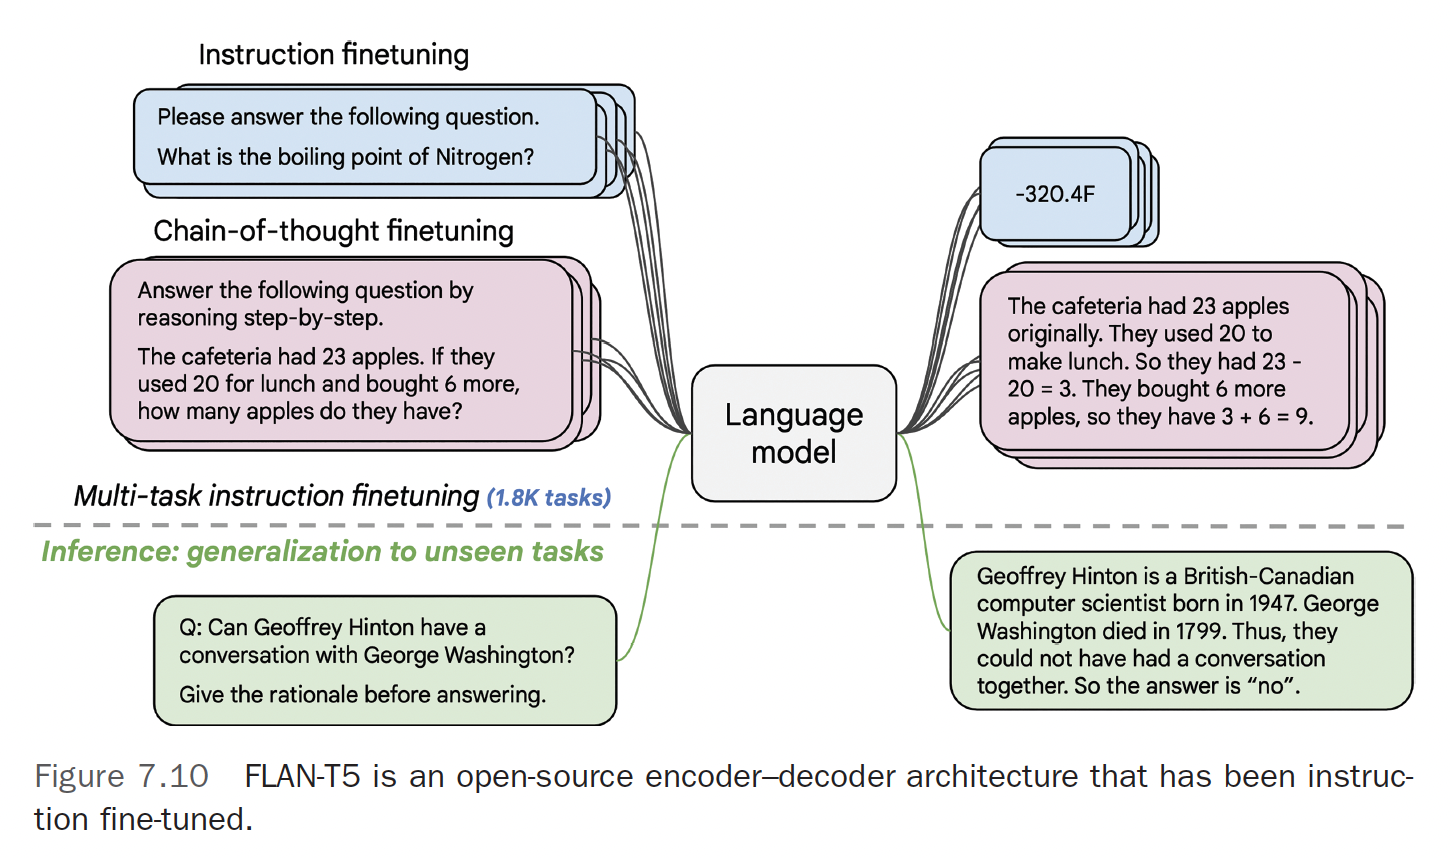

In [7]:
flan_t5_tokenizer = AutoTokenizer.from_pretrained('t5-align')

generation_kwargs = {
    "min_length": 64,
    # num_beans: it forces the model to look ahead and generate multiple
    # sequences, and then choose the best one. This tends to generate better
    # answers from small models
    "num_beams": 5,
    # prescence penalty: it means that the model cannot generate the same
    # n-gram twice (n=5 in this case), even if it has the best score. This promotes diversity
    "no_repeat_ngram_size": 5,
    "do_sample": True,  # sample from the top-k tokens instead of choosing the best one
    "pad_token_id": flan_t5_tokenizer.pad_token_id,
    "max_length": 256,
    "eos_token_id": flan_t5_tokenizer.eos_token_id,
}

In [28]:
ppo_trainer = PPOTrainer(
    config, flan_t5_model, flan_t5_model_ref, 
    flan_t5_tokenizer, dataset['train'], data_collator=collator
)


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


### Our RLF Loop

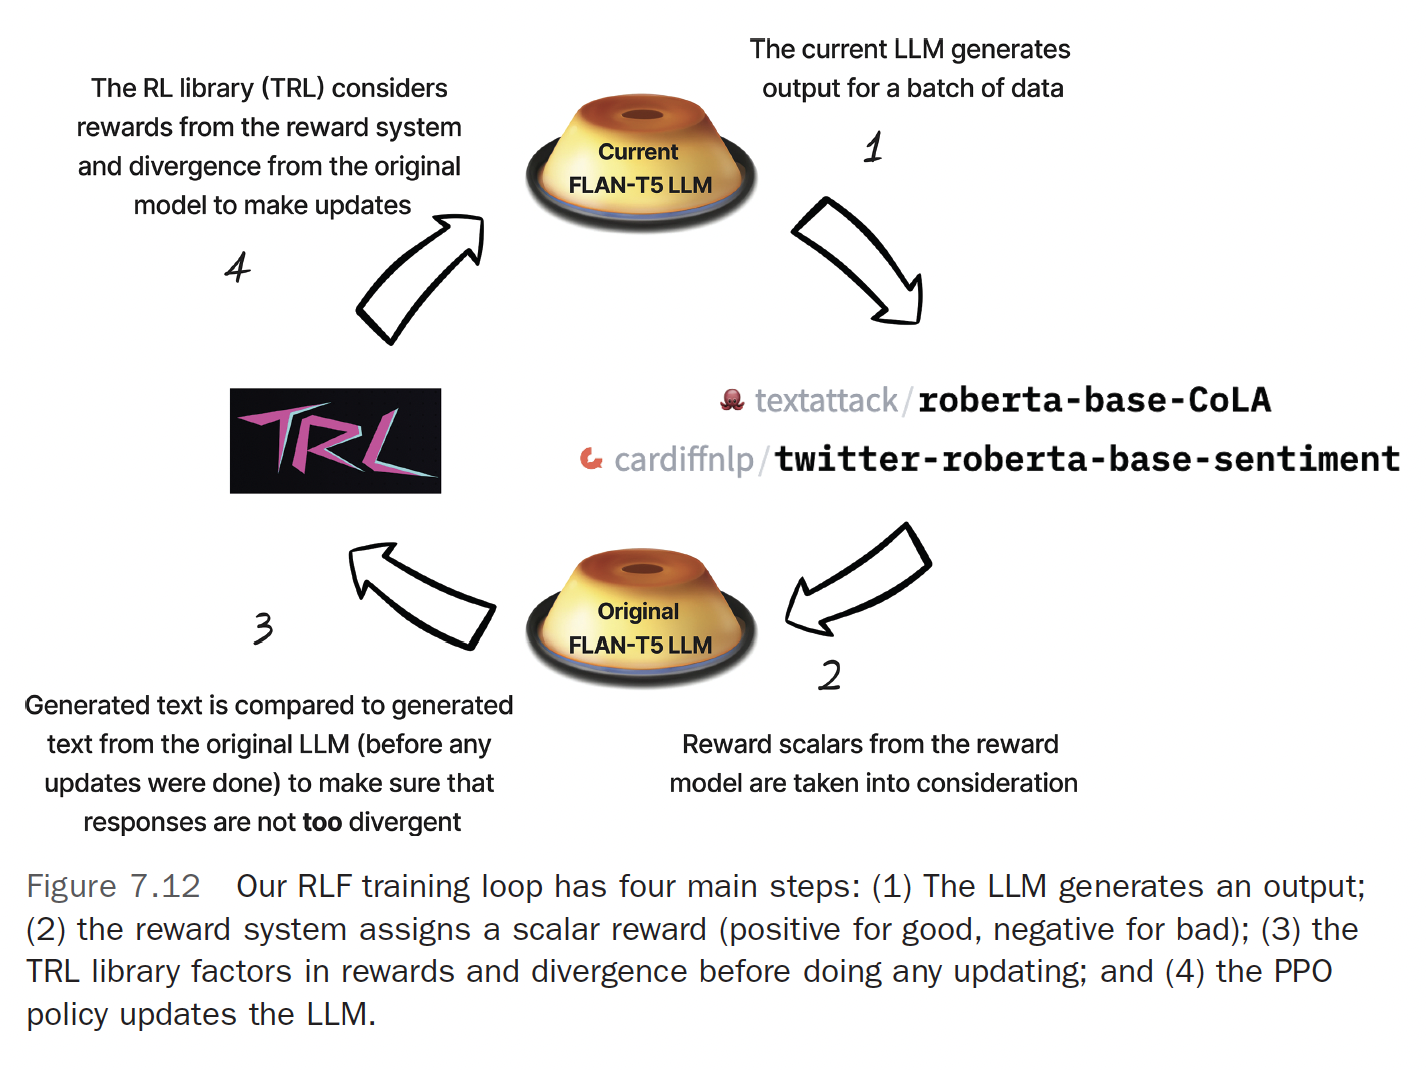

In this loop, we will not re

In [32]:
from tqdm.auto import tqdm
for epoch in tqdm(range(2)):
    for batch in tqdm(ppo_trainer.dataloader):
        game_data = dict()
        #### prepend the summarize token
        game_data["query"] = ['summarize: ' + b for b in batch["text"]]

        #### get response from flan-t5
        input_tensors = [_.squeeze() for _ in batch["input_ids"]]
        response_tensors = []
        for query in input_tensors:
            response = ppo_trainer.generate(query.squeeze(), **generation_kwargs)
            response_tensors.append(response.squeeze())
        
        game_data["response"] = [flan_t5_tokenizer.decode(r.squeeze(), skip_special_tokens=False) for r in response_tensors]

        #### reward system
        game_data["clean_response"] = [flan_t5_tokenizer.decode(r.squeeze(), skip_special_tokens=True) for r in response_tensors]
        game_data['cola_scores'] = get_cola_scores(game_data["clean_response"])
        game_data['neutral_scores'] = get_neutral_scores(game_data["clean_response"])
        rewards = game_data['neutral_scores']
        transposed_lists = zip(game_data['cola_scores'], game_data['neutral_scores'])
        # Calculate the averages for each index
        rewards = [1 * values[0] +  0.5 * values[1] for values in transposed_lists]
        rewards = [torch.tensor([_]) for _ in rewards]
        print(rewards)  # just to inspect :)

        #### Run PPO training
        stats = ppo_trainer.step(input_tensors, response_tensors, rewards)

        stats['env/reward'] = np.mean([r.cpu().numpy() for r in rewards])
        ppo_trainer.log_stats(stats, game_data, rewards)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[tensor([1.6643]), tensor([0.7271]), tensor([1.4417]), tensor([-0.0702])]
[tensor([2.6944]), tensor([0.9752]), tensor([1.6286]), tensor([1.5158])]
[tensor([-0.0008]), tensor([0.4814]), tensor([1.9548]), tensor([2.6616])]
[tensor([2.1580]), tensor([2.3857]), tensor([1.3361]), tensor([2.2725])]
[tensor([2.4017]), tensor([0.2072]), tensor([1.7085]), tensor([1.6407])]
[tensor([1.8583]), tensor([1.0760]), tensor([2.4011]), tensor([1.7472])]
[tensor([1.7080]), tensor([1.2387]), tensor([1.3943]), tensor([1.5025])]
[tensor([1.7732]), tensor([0.4342]), tensor([0.4583]), tensor([2.3639])]
[tensor([0.4473]), tensor([0.6166]), tensor([1.4349]), tensor([1.5386])]
[tensor([1.2178]), tensor([2.3100]), tensor([1.7020]), tensor([1.0058])]
[tensor([1.7477]), tensor([0.8768]), tensor([1.0646]), tensor([1.6837])]
[tensor([1.9990]), tensor([0.7264]), tensor([0.5998]), tensor([1.9179])]
[tensor([1.6276]), tensor([0.6442]), tensor([2.7029]), tensor([1.7158])]
[tensor([0.4866]), tensor([0.0283]), tensor([1.09

[tensor([1.6594]), tensor([2.3761]), tensor([0.7662]), tensor([2.7397])]
[tensor([2.2144]), tensor([2.1272]), tensor([2.0237]), tensor([2.1475])]
[tensor([2.1564]), tensor([1.9498]), tensor([0.8935]), tensor([0.4739])]
[tensor([1.2556]), tensor([1.6483]), tensor([1.9028]), tensor([1.9125])]
[tensor([1.5907]), tensor([0.5454]), tensor([0.9621]), tensor([2.1734])]
[tensor([0.7782]), tensor([1.7243]), tensor([1.8894]), tensor([0.6298])]
[tensor([1.0093]), tensor([2.3179]), tensor([1.1701]), tensor([1.0045])]
[tensor([1.0496]), tensor([0.3142]), tensor([1.8665]), tensor([1.1534])]
[tensor([2.0507]), tensor([2.0534]), tensor([1.3691]), tensor([1.9545])]
[tensor([2.1593]), tensor([2.0928]), tensor([2.1080]), tensor([2.3959])]
[tensor([1.6652]), tensor([1.9789]), tensor([2.2316]), tensor([2.3397])]
[tensor([1.8378]), tensor([2.3710]), tensor([0.3943]), tensor([1.6915])]
[tensor([1.5868]), tensor([1.9844]), tensor([2.5009]), tensor([0.2279])]
[tensor([2.2455]), tensor([0.4789]), tensor([2.4138

[tensor([2.3282]), tensor([2.1617]), tensor([0.1358]), tensor([2.1534])]
[tensor([1.6069]), tensor([2.0988]), tensor([0.8544]), tensor([0.7252])]
[tensor([1.5384]), tensor([-0.2575]), tensor([1.0486]), tensor([0.9342])]
[tensor([0.3580]), tensor([1.9356]), tensor([2.1436]), tensor([1.9204])]
[tensor([0.6610]), tensor([1.3874]), tensor([2.0528]), tensor([1.8857])]
[tensor([1.4101]), tensor([1.6327]), tensor([2.8138]), tensor([1.7273])]
[tensor([1.9100]), tensor([1.9711]), tensor([1.6012]), tensor([1.2046])]
[tensor([1.9510]), tensor([1.4954]), tensor([1.4794]), tensor([-0.0867])]
[tensor([2.4479]), tensor([2.0819]), tensor([1.1588]), tensor([2.2229])]
[tensor([1.6461]), tensor([1.8268]), tensor([2.3905]), tensor([2.1320])]
[tensor([1.6733]), tensor([1.6811]), tensor([2.2288]), tensor([0.0386])]
[tensor([1.7736]), tensor([1.6495]), tensor([1.3111]), tensor([1.7893])]
[tensor([1.0683]), tensor([1.9063]), tensor([2.1059]), tensor([2.2208])]
[tensor([0.8442]), tensor([1.8192]), tensor([1.14

  0%|          | 0/250 [00:00<?, ?it/s]

[tensor([1.8749]), tensor([2.1002]), tensor([0.4619]), tensor([2.2009])]
[tensor([-0.2595]), tensor([2.1702]), tensor([0.6282]), tensor([1.5227])]
[tensor([2.4463]), tensor([2.1031]), tensor([2.1948]), tensor([0.9886])]
[tensor([0.3495]), tensor([1.9100]), tensor([1.7899]), tensor([1.8099])]
[tensor([1.4847]), tensor([2.1366]), tensor([1.7825]), tensor([0.7873])]
[tensor([1.5680]), tensor([2.0813]), tensor([-0.0157]), tensor([0.4610])]
[tensor([1.6847]), tensor([1.6950]), tensor([2.1583]), tensor([1.8097])]
[tensor([1.6128]), tensor([2.3003]), tensor([1.8801]), tensor([1.8597])]
[tensor([2.4086]), tensor([1.4783]), tensor([2.0648]), tensor([0.7695])]
[tensor([2.4074]), tensor([2.0603]), tensor([1.4307]), tensor([0.6356])]
[tensor([0.7523]), tensor([2.3634]), tensor([1.6562]), tensor([1.9738])]
[tensor([1.8782]), tensor([1.0644]), tensor([2.0943]), tensor([2.0909])]
[tensor([1.4350]), tensor([1.5207]), tensor([2.1957]), tensor([1.0355])]
[tensor([1.6629]), tensor([1.9649]), tensor([1.43

[tensor([1.9926]), tensor([2.4725]), tensor([2.3633]), tensor([2.1871])]
[tensor([2.3230]), tensor([0.8742]), tensor([1.1158]), tensor([1.9274])]
[tensor([1.8124]), tensor([-0.1191]), tensor([0.7499]), tensor([2.1361])]
[tensor([2.3008]), tensor([2.6464]), tensor([2.9357]), tensor([2.4959])]
[tensor([1.8625]), tensor([1.2930]), tensor([2.0030]), tensor([2.3961])]
[tensor([1.8184]), tensor([0.9698]), tensor([1.3304]), tensor([0.5054])]
[tensor([1.4509]), tensor([2.1252]), tensor([0.8355]), tensor([1.7999])]
[tensor([1.8903]), tensor([2.5863]), tensor([2.1146]), tensor([0.9535])]
[tensor([2.0704]), tensor([1.2085]), tensor([1.6747]), tensor([1.9117])]
[tensor([0.5824]), tensor([1.7562]), tensor([1.6359]), tensor([1.5213])]
[tensor([1.5372]), tensor([2.0806]), tensor([1.7276]), tensor([1.6200])]
[tensor([0.7368]), tensor([1.1809]), tensor([2.0449]), tensor([2.5465])]
[tensor([1.7208]), tensor([1.0335]), tensor([1.3494]), tensor([1.6638])]
[tensor([1.9914]), tensor([1.9741]), tensor([1.964

[tensor([1.4527]), tensor([2.1755]), tensor([1.9061]), tensor([1.6288])]
[tensor([1.3506]), tensor([1.9411]), tensor([0.9642]), tensor([1.3626])]
[tensor([1.4529]), tensor([2.1071]), tensor([2.5724]), tensor([2.0128])]
[tensor([1.6369]), tensor([1.6254]), tensor([1.5298]), tensor([1.9483])]
[tensor([1.9011]), tensor([1.6879]), tensor([1.1697]), tensor([2.6425])]
[tensor([1.5887]), tensor([0.7473]), tensor([1.9151]), tensor([1.0674])]
[tensor([2.2003]), tensor([2.3505]), tensor([1.4355]), tensor([1.6642])]
[tensor([2.3433]), tensor([1.8754]), tensor([1.4583]), tensor([1.6367])]
[tensor([2.3289]), tensor([1.7538]), tensor([2.0565]), tensor([2.0623])]
[tensor([1.7221]), tensor([1.3491]), tensor([1.6159]), tensor([1.8322])]
[tensor([1.4908]), tensor([1.8268]), tensor([2.8994]), tensor([1.8084])]
[tensor([1.0242]), tensor([2.4404]), tensor([2.0394]), tensor([1.2263])]
[tensor([1.9548]), tensor([2.2524]), tensor([1.4035]), tensor([1.7245])]
[tensor([1.4231]), tensor([1.8720]), tensor([1.8983

In [22]:
flan_t5_model.save_pretrained("t5-align")
flan_t5_tokenizer.save_pretrained("t5-align")

In [ ]:
nytimes = '''Merriam-Webster notes that a “Pandora’s box” can be “anything that looks ordinary but may produce unpredictable harmful results.” I’ve been thinking a lot about Pandora’s boxes lately, because we Homo sapiens are doing something we’ve never done before: lifting the lids on two giant Pandora’s boxes at the same time, without any idea of what could come flying out.

One of these Pandora’s boxes is labeled “artificial intelligence,” and it is exemplified by the likes of ChatGPT, Bard and AlphaFold, which testify to humanity’s ability for the first time to manufacture something in a godlike way that approaches general intelligence, far exceeding the brainpower with which we evolved naturally.

The other Pandora’s box is labeled “climate change,” and with it we humans are for the first time driving ourselves in a godlike way from one climate epoch into another. Up to now, that power was largely confined to natural forces involving Earth’s orbit around the sun.

For me the big question, as we lift the lids simultaneously, is: What kind of regulations and ethics must we put in place to manage what comes screaming out?

Let’s face it, we did not understand how much social networks would be used to undermine the twin pillars of any free society — truth and trust. So if we approach generative A.I. just as heedlessly — if we again go along with Mark Zuckerberg’s reckless mantra at the dawn of social networks, “move fast and break things” — oh, baby, we are going to break things faster, harder and deeper than anyone can imagine.

“There was a failure of imagination when social networks were unleashed and then a failure to responsibly respond to their unimagined consequences once they permeated the lives of billions of people,” Dov Seidman, the founder and chairman of the HOW Institute for Society and LRN, told me. “We lost a lot of time — and our way — in utopian thinking that only good things could come from social networks, from just connecting people and giving people a voice. We cannot afford similar failures with artificial intelligence.”'''.strip()

# Old Summarizer

In [29]:
summary_list, sentiment_scores, cola_scores = [], [], []

for i in range(10):
    results = old_summarizer(f"{nytimes}", **generation_kwargs)
    summary_text = results[0]['summary_text']

    if summary_text.endswith('.') and '...' not in summary_text:
        print(f"Generated Summary {i+1}: {summary_text}")

        sentiment_score = get_neutral_scores([summary_text])
        sentiment_scores.extend(sentiment_score)
        print(f"Neutral Rewards for Summary {i+1}: {sentiment_score}")

        cola_score = get_cola_scores([summary_text])
        cola_scores.extend(cola_score)
        print(f"Cola Rewards for Summary {i+1}: {cola_score}")

        print('---------------------------')

average_sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
average_cola_score = sum(cola_scores) / len(cola_scores)

print(f'Average Neutral Reward: {average_sentiment_score}')
print(f'Average Cola Reward: {average_cola_score}')
print('---------------------------')


Generated Summary 1: “Pandora’s box” can be “anything that looks ordinary but may produce unpredictable harmful results. I’ve been thinking a lot about Pandora’s boxes lately, because we Homo sapiens are doing something we’ve never done before: lifting the lids on two giant Pandora’s boxes at the same time, without any idea of what could come flying out.
Neutral Rewards for Summary 1: [0.28202348947525024]
Cola Rewards for Summary 1: [1.1998964548110962]
---------------------------
Generated Summary 2: “Pandora’s box” can be “anything that looks ordinary but may produce unpredictable harmful results,” says Merriam-Webster, adding that humans are for the first time driving ourselves in a godlike way from one climate epoch into another. “So if we approach generative A.I. just as heedlessly—if we again go along with Mark Zuckerberg’s reckless mantra at the dawn of social networks, “move fast and break things”—oh, baby, we are going to break things faster, harder and deeper than anyone can

# New Summarizer

In [17]:
trained_tokenizer = AutoTokenizer.from_pretrained("t5-align")
new_summarizer = pipeline("summarization", 't5-align', tokenizer=trained_tokenizer)

Some weights of the model checkpoint at t5-align were not used when initializing T5ForConditionalGeneration: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
summary_list, sentiment_scores, cola_scores = [], [], []

for i in range(10):
    results = new_summarizer(f"{nytimes}", **generation_kwargs)
    summary_text = results[0]['summary_text']

    if summary_text.endswith('.') and '...' not in summary_text:
        print(f"Generated Summary {i+1}: {summary_text}")

        sentiment_score = get_neutral_scores([summary_text])
        sentiment_scores.extend(sentiment_score)
        print(f"Neutral Rewards for Summary {i+1}: {sentiment_score}")

        cola_score = get_cola_scores([summary_text])
        cola_scores.extend(cola_score)
        print(f"Cola Rewards for Summary {i+1}: {cola_score}")

        print('---------------------------')

average_sentiment_score = sum(sentiment_scores) / len(sentiment_scores)
average_cola_score = sum(cola_scores) / len(cola_scores)

print(f'Average Neutral Reward: {average_sentiment_score}')
print(f'Average Cola Reward: {average_cola_score}')
print('---------------------------')


Generated Summary 1: “Pandora’s box” can be “anything that looks ordinary but may produce unpredictable harmful results,” says Merriam-Webster. “If we approach generative A.I. just as heedlessly—if we again go along with Mark Zuckerberg’s reckless mantra at the dawn of social networks, “move fast and break things”—oh, baby, we are going to break things faster, harder and deeper than anyone can imagine.
Neutral Rewards for Summary 1: [0.24494782090187073]
Cola Rewards for Summary 1: [1.1494851112365723]
---------------------------
Generated Summary 2: Dov Seidman: We lost a lot of time—and our way—in utopian thinking that only good things could come from social networks, from just connecting people and giving people a voice, oh, baby, we are going to break things faster, harder and deeper than anyone can imagine.
Neutral Rewards for Summary 2: [0.22071519494056702]
Cola Rewards for Summary 2: [0.3188014030456543]
---------------------------
Generated Summary 8: “Pandora’s box” can be “a

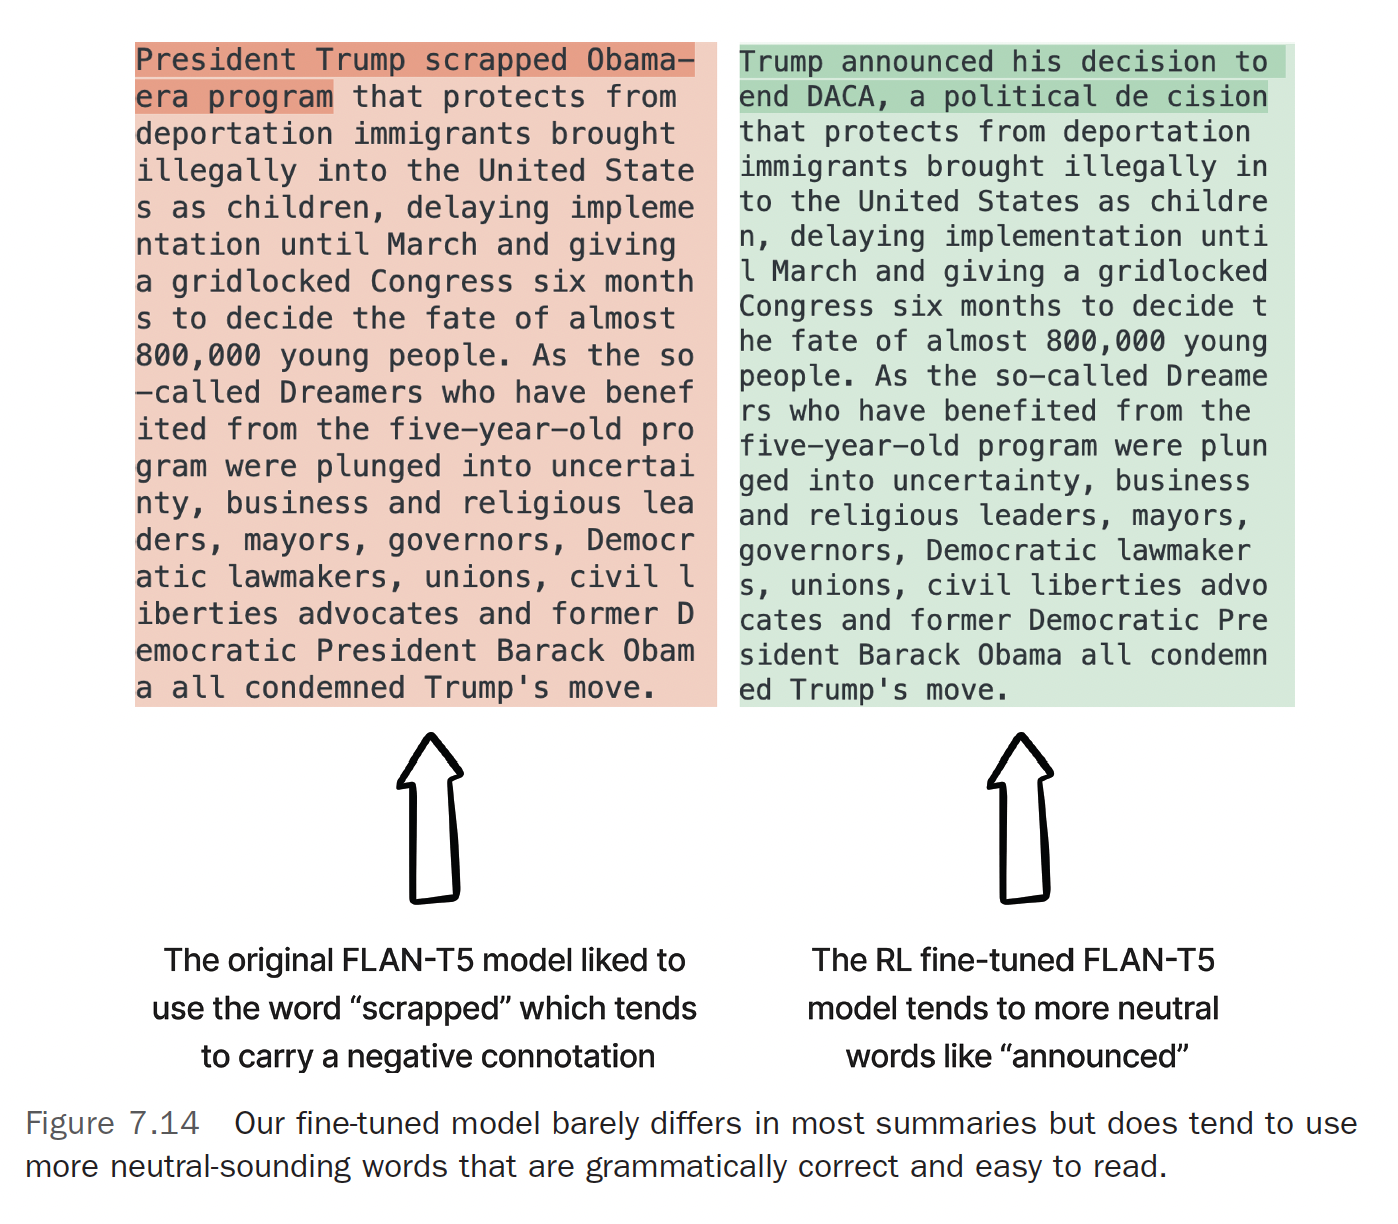